In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

plt.style.use('ggplot')

# Data generation

In [2]:
def generate_dataset(n_samples=10000, seed=None, history_1_proba=1/3):
  np.random.seed(seed)

  history_1_conversion_proba = 0.5
  history_2_conversion_proba = 0.6

  data_rows = []
  for i in range(n_samples):
    sampled_history = np.random.choice([1, 2], p=[history_1_proba, 1 - history_1_proba])
    if sampled_history == 1:
      data_rows += [
        {"uid": i, "features": [1, 0], "conversion": int(np.random.rand() < history_1_conversion_proba), "display type": "Display A"}
      ]
    elif sampled_history == 2:
      data_rows += [
        {"uid": i, "features": [1, 0], "conversion": 0, "display type": "Display A"},
        {"uid": i, "features": [0, 1], "conversion": int(np.random.rand() < history_2_conversion_proba), "display type": "Display B"},
      ]

  data = pd.DataFrame(data_rows)

  total_uid_rewards_df = data.groupby('uid').agg({'conversion': 'sum'}).reset_index()
  total_uid_rewards_df.columns = ['uid', 'total_uid_rewards']
  data = data.merge(total_uid_rewards_df)

  return data

generate_dataset(n_samples=5).head()

,uid,features,conversion,display type,total_uid_rewards
0,0,"[1, 0]",0,Display A,1
1,0,"[0, 1]",1,Display B,1
2,1,"[1, 0]",1,Display A,1
3,2,"[1, 0]",0,Display A,0
4,3,"[1, 0]",0,Display A,0


In [3]:
def additivity_likelihood(model_predictions, timeline_ids, uid_rewards):
  # Gather the attributions per timeline and obtain the sum of the predictions per timeline
  predictions_per_display = pd.DataFrame({
      'timeline_id': timeline_ids,
      'prediction': model_predictions,
      'uid_reward': uid_rewards,
  })

  sum_predictions_by_timeline = (
    predictions_per_display
    .groupby('timeline_id')
    .agg(sum_predictions=('prediction', 'sum'), uid_reward=('uid_reward', 'first'))
    .reset_index()
  )
    
  additivity_llh = (
    sum_predictions_by_timeline['uid_reward'] 
    * np.log(sum_predictions_by_timeline['sum_predictions'])
    - sum_predictions_by_timeline['sum_predictions']
  )
  
  return additivity_llh.mean()


In [4]:
def average_display_valuation_per_display_type(dataset):
  return (
    dataset.groupby('display type')
      .agg(history_valuation=('labels', 'mean'))
      .reset_index()
  )


def compute_display_valuations_by_averaging(dataset):
  history_valuation = average_display_valuation_per_display_type(dataset)
  return dataset.merge(history_valuation, on='display type', how='left')


def run_one_iteration(original_dataset, compute_display_valuations):
  current_dataset = original_dataset.copy()
  
  # Step 2, compute valuations
  current_dataset = compute_display_valuations(current_dataset)
  
  # Step 3, compute new labels proportionnaly to the display valuations
  total_uid_valuation = (
      current_dataset
      .groupby('uid')
      .agg(total_uid_valuation=('history_valuation', 'sum'))
      .reset_index()
  )
  
  merged_dataset = current_dataset.merge(total_uid_valuation, on='uid', how='left')
  current_dataset['labels'] = (
    merged_dataset['history_valuation']
    / merged_dataset['total_uid_valuation']
    * merged_dataset['total_uid_rewards']
  )
  
  return current_dataset[original_dataset.columns]


def compute_metrics(original_dataset, compute_display_valuations):
  current_dataset = original_dataset.copy()
  
  history_valuation = average_display_valuation_per_display_type(current_dataset)
  history_valuation_dict = {
    row['display type']: row['history_valuation']
    for _, row in history_valuation.iterrows()
  }
  
  dataset_with_valuations = current_dataset.merge(history_valuation, on='display type', how='left')
    
  current_additivity_likelihood = additivity_likelihood(
      dataset_with_valuations['history_valuation'], 
      dataset_with_valuations['uid'], 
      dataset_with_valuations['total_uid_rewards']
  )
  
  return history_valuation_dict, current_additivity_likelihood

In [5]:
current_dataset = generate_dataset(seed=2390)
# Initialize with last touch: last display beforethe conversion gets all credit
current_dataset['labels'] = current_dataset['conversion'].values

history_valuations = []
additivity_likelihoods = []
for _ in range(30):
  current_dataset = run_one_iteration(current_dataset, compute_display_valuations_by_averaging)
  history_valuation, current_additivity_likelihood = compute_metrics(current_dataset, compute_display_valuations_by_averaging)
  history_valuations += [history_valuation]
  additivity_likelihoods += [current_additivity_likelihood]

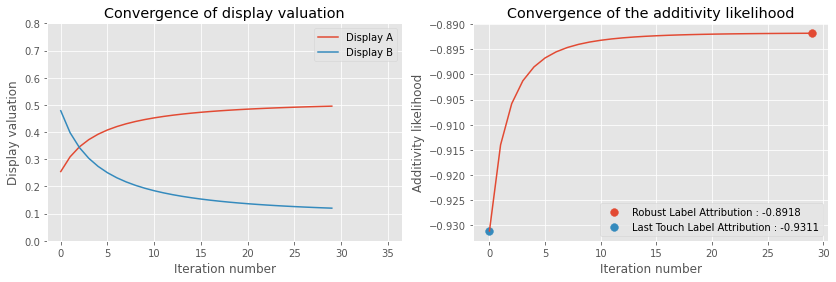

In [6]:
def plot_history_valuation(history_valuations, ax):
  display_types = sorted(list(history_valuations[0].keys()))
  for display_type in display_types:
      ax.plot([valuations[display_type] for valuations in history_valuations], label=display_type)

  ax.set_title('Convergence of display valuation')
  ax.set_ylabel('Display valuation')
  ax.set_xlabel('Iteration number')
  ax.set_xlim((ax.get_xlim()[0], ax.get_xlim()[1] * 1.2))  # Add some space on the right
  ax.set_ylim([0., 0.8])
  ax.legend(loc='upper right')

def plot_additivity_likelihood(additivity_likelihoods, ax):
  ax.set_title('Convergence of the additivity likelihood')
  ax.plot(additivity_likelihoods)
  ax.set_ylabel('Additivity likelihood')
  ax.set_xlabel('Iteration number')

  llh_init = additivity_likelihoods[0]
  llh_conv = additivity_likelihoods[-1]
  ax.scatter(len(additivity_likelihoods) - 1, llh_conv, s=60, label=f'Robust Label Attribution : {llh_conv:.4f}', c='C0')
  ax.scatter(0, llh_init, s=60, label=f'Last Touch Label Attribution : {llh_init:.4f}', c='C1')
  ax.legend()

def plot_metrics(history_valuations, additivity_likelihoods):
  fig, axes = plt.subplots(1, 2, figsize=(14, 4))
  plot_history_valuation(history_valuations, axes[0])
  plot_additivity_likelihood(additivity_likelihoods, axes[1])
  
plot_metrics(history_valuations, additivity_likelihoods)

In [7]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_history_valuation(history_valuations, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
ax.set_title(None)
plt.savefig('history_valuation_with_averaging.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_additivity_likelihood(additivity_likelihoods, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
ax.set_title(None)
plt.savefig('additivity_likelihoods_with_averaging.pdf')
plt.close(fig)

In [8]:
class CountinuousLogisticRegression(LogisticRegression):
  
  @staticmethod
  def from_countinuous_to_weighted_binary_labels(labels, features):
    """Transforms a dataset with continuous labels into a bigger dataset with weighted 
    binary labels. See explanation above.
    """
    weigths_positive = labels
    weigths_negative = 1 - labels
    label_positive = np.ones_like(labels)
    label_negative = np.zeros_like(labels)

    weights = np.hstack((weigths_positive, weigths_negative))
    weighted_labels = np.hstack((label_positive, label_negative))
    weighted_features = np.vstack((features, features))

    return weighted_labels, weighted_features, weights
  
  def fit(self, X, y):
    # 1. Generate dataset, use continuous labels to weighted dataset trick
    weighted_labels, weighted_features, weights = self.from_countinuous_to_weighted_binary_labels(y, X)

    # 2. Train model
    return LogisticRegression.fit(self, weighted_features, weighted_labels, sample_weight=weights)

In [9]:
def compute_display_valuations_with_logistic_regression(dataset):
  current_dataset = dataset.copy()
  
  labels = current_dataset['labels'].values
  features = np.vstack(current_dataset['features'].values)
  
  model = CountinuousLogisticRegression(max_iter=1000, penalty='none')
  model.fit(features, labels)
  model_predictions = model.predict_proba(features)[:, 1]
  
  current_dataset['history_valuation'] = model_predictions
  return current_dataset

In [10]:
current_dataset = generate_dataset(seed=2390)
# Initialize with last click
current_dataset['labels'] = current_dataset['conversion'].values

history_valuations = []
additivity_likelihoods = []
for _ in range(30):
  current_dataset = run_one_iteration(current_dataset, compute_display_valuations_with_logistic_regression)
  history_valuation, current_additivity_likelihood = compute_metrics(current_dataset, compute_display_valuations_with_logistic_regression)
  history_valuations += [history_valuation]
  additivity_likelihoods += [current_additivity_likelihood]

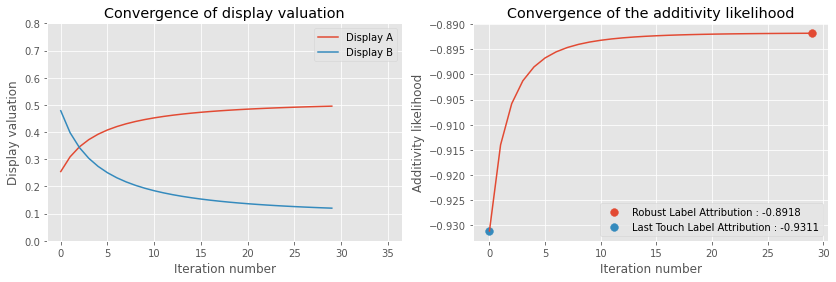

In [11]:
plot_metrics(history_valuations, additivity_likelihoods)

# Data distribution robustness

In [12]:
valuations_given_proba_robust_label_attribution = {}
valuations_given_proba_last_touch = {}
history_1_probas = np.linspace(0, 1, 11)[1:-1]

for history_1_proba in history_1_probas:
  current_dataset = generate_dataset(seed=2390, history_1_proba=history_1_proba)
  # Initialize with last touch: last display beforethe conversion gets all credit
  current_dataset['labels'] = current_dataset['conversion'].values

  history_valuations = []
  additivity_likelihoods = []
  for i in range(100):
    current_dataset = run_one_iteration(current_dataset, compute_display_valuations_by_averaging)
    history_valuation, _ = compute_metrics(current_dataset, compute_display_valuations_by_averaging)

    if i == 0:
      valuations_given_proba_last_touch[history_1_proba] = history_valuation

  valuations_given_proba_robust_label_attribution[history_1_proba] = history_valuation

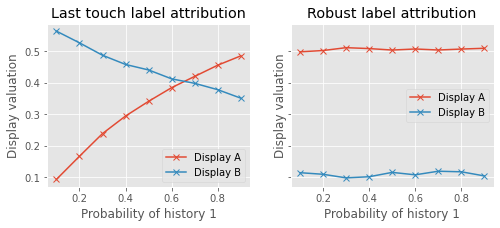

In [13]:
def plot_display_valuation_given_history_proba(valuations_given_proba, ax):
  for display in ['Display A', 'Display B']:
    ax.plot(
      history_1_probas, 
      [valuations_given_proba[p][display] for p in history_1_probas], 
      label=f'{display}',
      marker='x',
    )

    ax.legend()
    ax.set_xlabel('Probability of history 1')
    ax.set_ylabel('Display valuation')

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
plot_display_valuation_given_history_proba(valuations_given_proba_last_touch, axes[0])
axes[0].set_title('Last touch label attribution')
plot_display_valuation_given_history_proba(valuations_given_proba_robust_label_attribution, axes[1])
axes[1].set_title('Robust label attribution')
None

In [14]:
# Saving figures for paper
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_display_valuation_given_history_proba(valuations_given_proba_last_touch, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
plt.savefig('distributional_robustness_last_touch_label_attribution.pdf')
plt.close(fig)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_display_valuation_given_history_proba(valuations_given_proba_robust_label_attribution, ax)
fig.subplots_adjust(bottom=0.15, left=0.15, top=0.95, right=0.95)
plt.savefig('distributional_robustness_robust_label_attribution.pdf')
plt.close(fig)